Conversion reaction
===================

In [1]:
# install if not done yet
# !apt install libatlas-base-dev swig
# %pip install pypesto[amici] --quiet

In [2]:
import importlib
import os
import sys

import amici
import amici.plotting
import numpy as np

import pypesto
import pypesto.optimize as optimize
import pypesto.visualize as visualize

# sbml file we want to import
sbml_file = "conversion_reaction/model_conversion_reaction.xml"
# name of the model that will also be the name of the python module
model_name = "model_conversion_reaction"
# directory to which the generated model code is written
model_output_dir = "tmp/" + model_name

## Compile AMICI model

In [3]:
# import sbml model, compile and generate amici module
sbml_importer = amici.SbmlImporter(sbml_file)
sbml_importer.sbml2amici(model_name, model_output_dir, verbose=False)

## Load AMICI model

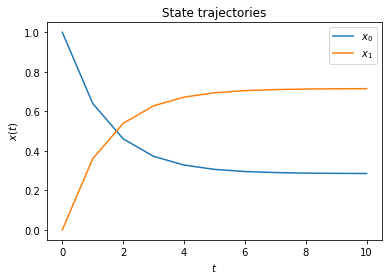

In [4]:
# load amici module (the usual starting point later for the analysis)
sys.path.insert(0, os.path.abspath(model_output_dir))
model_module = importlib.import_module(model_name)
model = model_module.getModel()
model.requireSensitivitiesForAllParameters()
model.setTimepoints(np.linspace(0, 10, 11))
model.setParameterScale(amici.ParameterScaling.log10)
model.setParameters([-0.3, -0.7])
solver = model.getSolver()
solver.setSensitivityMethod(amici.SensitivityMethod.forward)
solver.setSensitivityOrder(amici.SensitivityOrder.first)

# how to run amici now:
rdata = amici.runAmiciSimulation(model, solver, None)
amici.plotting.plotStateTrajectories(rdata)
edata = amici.ExpData(rdata, 0.2, 0.0)

## Optimize

In [5]:
# create objective function from amici model
# pesto.AmiciObjective is derived from pesto.Objective,
# the general pesto objective function class
objective = pypesto.AmiciObjective(model, solver, [edata], 1)

# create optimizer object which contains all information for doing the optimization
optimizer = optimize.ScipyOptimizer(method="ls_trf")

# create problem object containing all information on the problem to be solved
problem = pypesto.Problem(objective=objective, lb=[-2, -2], ub=[2, 2])

# do the optimization
result = optimize.minimize(
    problem=problem, optimizer=optimizer, n_starts=100, filename=None
)

100%|██████████| 100/100 [00:07<00:00, 13.61it/s]


## Visualize

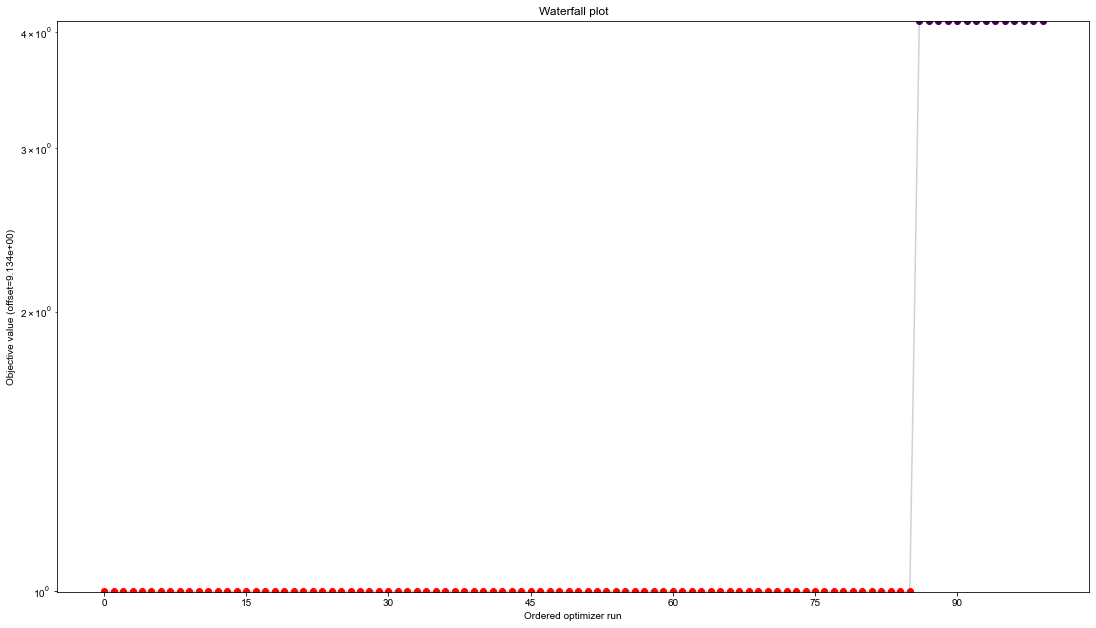

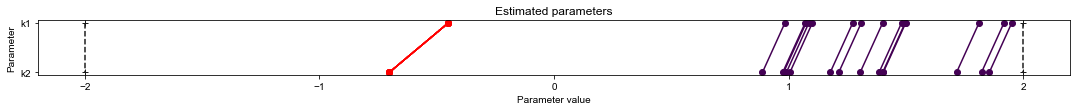

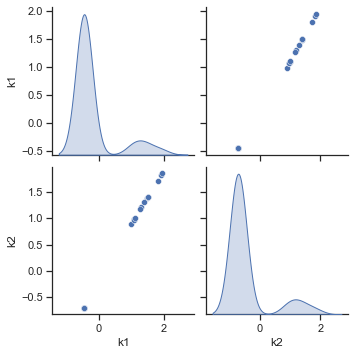

In [6]:
visualize.waterfall(result)
visualize.parameters(result)
visualize.optimization_scatter(result=result)

## Profiles

In [7]:
import pypesto.profile as profile

profile_options = profile.ProfileOptions(
    min_step_size=0.0005,
    delta_ratio_max=0.05,
    default_step_size=0.005,
    ratio_min=0.01,
)

result = profile.parameter_profile(
    problem=problem,
    result=result,
    optimizer=optimizer,
    profile_index=np.array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]),
    result_index=0,
    profile_options=profile_options,
    filename=None,
)

100%|██████████| 11/11 [00:01<00:00,  5.75it/s]


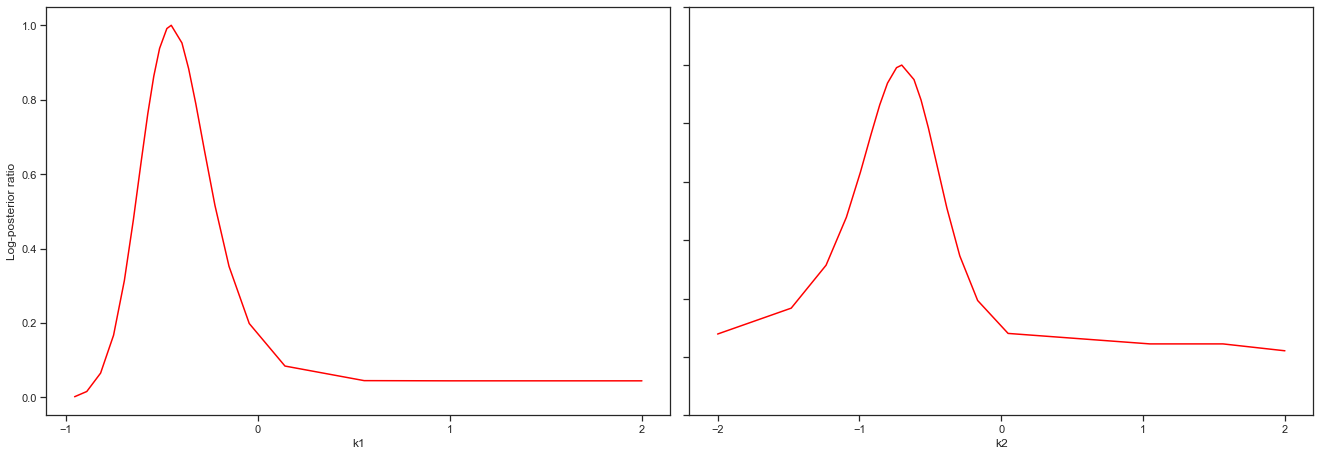

In [8]:
# specify the parameters, for which profiles should be computed
ax = visualize.profiles(result)

## Sampling

In [9]:
import pypesto.sample as sample

sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=3
)

result = sample.sample(
    problem, n_samples=10000, sampler=sampler, result=result, filename=None
)

100%|██████████| 10000/10000 [01:07<00:00, 148.81it/s]
Elapsed time: 76.66041799999999


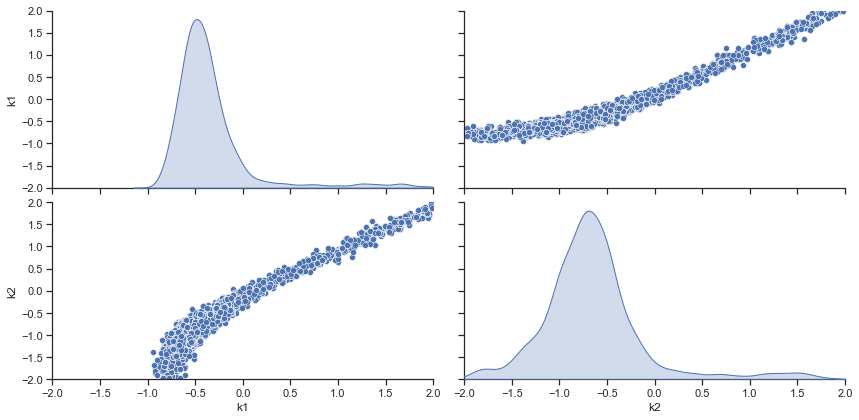

In [10]:
ax = visualize.sampling_scatter(result, size=[13, 6])

## Predict

In [11]:
# Let's create a function, which predicts the ratio of x_1 and x_0
import pypesto.predict as predict


def ratio_function(amici_output_list):
    # This (optional) function post-processes the results from AMICI and must accept one input:
    # a list of dicts, with the fields t, x, y[, sx, sy - if sensi_orders includes 1]
    # We need to specify the simulation condition: here, we only have one, i.e., it's [0]
    x = amici_output_list[0]["x"]
    ratio = x[:, 1] / x[:, 0]
    # we need to output also at least one simulation condition
    return [ratio]


# create pypesto prediction function
predictor = predict.AmiciPredictor(
    objective, post_processor=ratio_function, output_ids=["ratio"]
)

# run prediction
prediction = predictor(x=model.getUnscaledParameters())

In [12]:
dict(prediction)

{'conditions': [{'timepoints': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
   'output_ids': ['ratio'],
   'x_names': ['k1', 'k2'],
   'output': array([0.        , 1.95196396, 2.00246152, 2.00290412, 2.00290796,
          2.00290801, 2.00290801, 2.002908  , 2.002908  , 2.002908  ,
          2.002908  ]),
   'output_sensi': None,
   'output_weight': None,
   'output_sigmay': None}],
 'condition_ids': ['condition_0'],
 'comment': None,
 'parameter_ids': ['k1', 'k2']}

## Analyze parameter ensembles

In [13]:
# We want to use the sample result to create a prediction
from pypesto.ensemble import ensemble

# first collect some vectors from the sampling result
vectors = result.sample_result.trace_x[0, ::20, :]

# create the collection
my_ensemble = ensemble.Ensemble(
    vectors,
    x_names=problem.x_names,
    ensemble_type=ensemble.EnsembleType.sample,
    lower_bound=problem.lb,
    upper_bound=problem.ub,
)

# we can also perform an approximative identifiability analysis
summary = my_ensemble.compute_summary()
identifiability = my_ensemble.check_identifiability()
print(identifiability.transpose())

parameterId               k1        k2
parameterId               k1        k2
lowerBound                -2        -2
upperBound                 2         2
ensemble_mean      -0.575923 -0.349279
ensemble_std        0.125729  0.111493
ensemble_median    -0.575923 -0.349279
within lb: 1 std        True      True
within ub: 1 std        True      True
within lb: 2 std        True      True
within ub: 2 std        True      True
within lb: 3 std        True      True
within ub: 3 std        True      True
within lb: perc 5       True      True
within lb: perc 20      True      True
within ub: perc 80      True      True
within ub: perc 95      True      True


In [14]:
# run a prediction
ensemble_prediction = my_ensemble.predict(
    predictor, prediction_id="ratio_over_time"
)

# go for some analysis
prediction_summary = ensemble_prediction.compute_summary(
    percentiles_list=(1, 5, 10, 25, 75, 90, 95, 99)
)
dict(prediction_summary)

  0%|          | 0/2 [00:00<?, ?it/s]Executing task 0.
Executing task 1.
100%|██████████| 2/2 [00:00<00:00, 116.57it/s]


{'mean': <pypesto.result.predict.PredictionResult at 0x7fefc9a91970>,
 'std': <pypesto.result.predict.PredictionResult at 0x7fefc9a91190>,
 'median': <pypesto.result.predict.PredictionResult at 0x7fefc9a910d0>,
 'percentile 1': <pypesto.result.predict.PredictionResult at 0x7fefc9a914f0>,
 'percentile 5': <pypesto.result.predict.PredictionResult at 0x7fefc9a913a0>,
 'percentile 10': <pypesto.result.predict.PredictionResult at 0x7fefc9a7b790>,
 'percentile 25': <pypesto.result.predict.PredictionResult at 0x7fefc9a7b1f0>,
 'percentile 75': <pypesto.result.predict.PredictionResult at 0x7fefc9a7b7c0>,
 'percentile 90': <pypesto.result.predict.PredictionResult at 0x7fefc9a7ba00>,
 'percentile 95': <pypesto.result.predict.PredictionResult at 0x7fefc9a7bac0>,
 'percentile 99': <pypesto.result.predict.PredictionResult at 0x7fefc9a7b160>}